**<font color = black size=6>实验十二：神经网络</font>**

In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function
import torch.utils.data as Data
import os  

本实验使用Pytorch框架搭建神经网络，其他类似的框架还有TensorFlow。若同学对TensorFlow框架更为熟悉，可使用TensorFlow完成本次实验

**<font color = blue size=4>第一部分:PyTorch介绍</font>**

这里介绍一小部分PyTorch常用的库和函数，更多需求可参阅[PyTorch官方教程](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)以及[PyTorch官方文档](https://pytorch.org/docs/stable/index.html)。

In [377]:
print(torch.__version__) # 输出当前版本

1.12.1


**<font color = green size=3>1.Tensor</font>**

Tensor与NumPy中的ndarray很相似，但Tensor可以利用GPU来加速计算（本次实验中暂不涉及这部分内容）。

1.1. Tensor的创建

In [378]:
# 创建一个未初始化的Tensor
x = torch.empty(2, 3)
print(x)

# 从一个列表创建Tensor
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 创建一个随机Tensor
x = torch.rand([3, 4])
print(x)

# 创建一个全零Tensor
x = torch.zeros([2, 3])
print(x)

# 创建一个全一Tensor
x = torch.ones([2, 3])
print(x)

tensor([[0.0000, 4.3750, 0.0000],
        [0.0000, 0.0000, 4.6602]])
tensor([[1, 2, 3],
        [4, 5, 6]])
tensor([[0.4984, 0.0829, 0.0763, 0.0897],
        [0.9556, 0.1520, 0.0471, 0.2106],
        [0.1513, 0.7917, 0.5539, 0.3053]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])


1.2. Tensor的运算

In [379]:
# 加减法
x = torch.tensor([[1,2,3],
                  [4,5,6]])
y = torch.tensor([[6,5,4],
                  [3,2,1]])
print(x + y)
print(x - y)

# 对应位置相乘
print(x * y)
print(x.mul(y))

# 矩阵乘法
print(x.matmul(y.T))
print(x @ y.T)

# reshape
print(x.reshape(3, 2))

# 拼接
print(torch.cat([x,y], dim=0)) # 纵向拼接
print(torch.cat([x,y], dim=1)) # 横向拼接

tensor([[7, 7, 7],
        [7, 7, 7]])
tensor([[-5, -3, -1],
        [ 1,  3,  5]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[ 6, 10, 12],
        [12, 10,  6]])
tensor([[28, 10],
        [73, 28]])
tensor([[28, 10],
        [73, 28]])
tensor([[1, 2],
        [3, 4],
        [5, 6]])
tensor([[1, 2, 3],
        [4, 5, 6],
        [6, 5, 4],
        [3, 2, 1]])
tensor([[1, 2, 3, 6, 5, 4],
        [4, 5, 6, 3, 2, 1]])


1.3. Tensor与ndarray的相互转换

In [380]:
x = torch.tensor([[1,2,3],[4,5,6]])
print(x)

# 从Tensor转换到ndarray
y = x.numpy()
print(y)

# Tensor与ndarray是共享空间的
x[:]=0
print(y)

# 从ndarray到Tensor
z = torch.from_numpy(y)
print(z)

tensor([[1, 2, 3],
        [4, 5, 6]])
[[1 2 3]
 [4 5 6]]
[[0 0 0]
 [0 0 0]]
tensor([[0, 0, 0],
        [0, 0, 0]])


**<font color = green size=3>2.梯度计算</font>**

2.1 梯度计算

In [381]:
#定义变量
a = torch.tensor([[1., 2.]], requires_grad=True)
b = torch.tensor([[3.], [4.]])
c = torch.tensor(5., requires_grad=True)

#计算输出
z = a @ b + c

#自动计算梯度
z.backward()

#输出叶子节点的梯度
print(a.grad) #z对a的梯度
print(b.grad) #由于b默认requires_grad为false，因此无法计算梯度，输出为None
print(c.grad) #z对c的梯度

tensor([[3., 4.]])
None
tensor(1.)


2.2 梯度清零

In [382]:
#支持多种运算求梯度，如torch.mean(),torch.sum()等
a = torch.ones(20, requires_grad=True)
z = torch.sum(torch.sigmoid(a))
z.backward()
print("梯度（a.grad）:", a.grad)


#多次求梯度时梯度会累加，可使用tensor.grad.zero_()进行手动清零
x = torch.tensor(2., requires_grad=True)
y = x ** 2
y.backward()
print("求梯度后的结果（x.grad）:", x.grad)

z = x + 3
x.grad.zero_()  #可以将这句进行手动清零的代码注释掉后查看输出结果，来看到梯度清零的作用
z.backward()
print("求梯度后的结果（x.grad）:", x.grad)


梯度（a.grad）: tensor([0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966, 0.1966,
        0.1966, 0.1966])
求梯度后的结果（x.grad）: tensor(4.)
求梯度后的结果（x.grad）: tensor(1.)


**<font color = green size=3>3. 神经网络</font>**

3.1 神经网络的构建

In [383]:
# 定义神经网络模型，继承自nn.Module
class Net(nn.Module):
    #输入层的维度为 input_dim
    #隐藏层的维度为 hidden_dim
    #输出层的维度为 output_dim
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        #激活函数relu，用于在全连接层之间加入非线性变换
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out1 = self.relu(out)
        out2 = self.fc2(out1)
        return out1,out2


# 创建神经网络模型实例并输出
net = Net(10,5,1)
print(net)

Net(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)


3.2 神经网络参数查询

In [384]:
# 该神经网络中可学习的参数可以通过net.parameters()访问
params = list(net.parameters())
print([params[i].size() for i in range(len(params))])  
print("Parameters:",params)

[torch.Size([5, 10]), torch.Size([5]), torch.Size([1, 5]), torch.Size([1])]
Parameters: [Parameter containing:
tensor([[ 0.2254,  0.1326, -0.2645, -0.2574,  0.1168, -0.0413,  0.0550,  0.0943,
         -0.2911, -0.0972],
        [-0.1666,  0.2227,  0.1626, -0.1171,  0.1549,  0.1910, -0.1510, -0.2714,
         -0.0763, -0.2110],
        [-0.2266,  0.1093, -0.3015,  0.0005,  0.0224, -0.0306, -0.2671,  0.2207,
         -0.1438,  0.0893],
        [-0.0893,  0.0357,  0.2323,  0.1205,  0.2425, -0.2000, -0.0400, -0.0605,
         -0.0683,  0.1537],
        [-0.2201, -0.2474, -0.0028, -0.0483,  0.0982,  0.2857, -0.0210, -0.0109,
          0.1122,  0.1370]], requires_grad=True), Parameter containing:
tensor([ 0.2239,  0.0632, -0.2579, -0.0268,  0.0507], requires_grad=True), Parameter containing:
tensor([[-0.1764, -0.3354, -0.0063, -0.1894, -0.2073]], requires_grad=True), Parameter containing:
tensor([0.1283], requires_grad=True)]


3.3 神经网络前向传播

In [385]:
net.eval()
#输入维度为10，生成数据
input=torch.ones([1,10])
input=input.float()

# 进行一次forward()前向传播
output1, output2  = net(input) 

# 前向传播并输出每一层的输出值
print("Output of first layer:", output1)
print("Output of second layer:", output2)

Output of first layer: tensor([[0.0000, 0.0000, 0.0000, 0.2999, 0.1334]], grad_fn=<ReluBackward0>)
Output of second layer: tensor([[0.0439]], grad_fn=<AddmmBackward0>)


3.4 神经网络反向传播

In [386]:
loss_fn = nn.MSELoss()
target = torch.randn(1, 1)
loss = loss_fn(output2, target)

# 反向传播并输出每一层的梯度
net.zero_grad()
loss.backward()

print("Gradients of first layer:")
print(net.fc1.weight.grad)
print(net.fc1.bias.grad)

print("Gradients of second layer:")
print(net.fc2.weight.grad)
print(net.fc2.bias.grad)

Gradients of first layer:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.2294, -0.2294, -0.2294, -0.2294, -0.2294, -0.2294, -0.2294, -0.2294,
         -0.2294, -0.2294],
        [-0.2512, -0.2512, -0.2512, -0.2512, -0.2512, -0.2512, -0.2512, -0.2512,
         -0.2512, -0.2512]])
tensor([ 0.0000,  0.0000,  0.0000, -0.2294, -0.2512])
Gradients of second layer:
tensor([[0.0000, 0.0000, 0.0000, 0.3633, 0.1616]])
tensor([1.2115])


3.5 训练神经网络的全过程例子

In [387]:
# 创建一个简单的线性回归模型
model = nn.Linear(1, 1)
print(list(model.parameters()))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch=100

#生成数据
inputs = torch.tensor([[1.0], [2.0], [3.0]])
labels = torch.tensor([[2.0], [4.0], [6.0]])

# 模拟训练过程
for epoch in range(Epoch):
    # 模拟输入数据和标签
    
    # 前向传播
    outputs = model(inputs)

    # 计算损失
    loss = criterion(outputs, labels)
    
    #梯度清零
    optimizer.zero_grad()
    
    
    # 反向传播
    loss.backward()

    
    # 更新参数
    optimizer.step()

    # 打印梯度值
    print('Epoch [{}/{}], Loss: {}'.format(epoch+1,Epoch, loss),'. Gradient: {}'.format(model.weight.grad))
    #print('Gradient: {}'.format(model.weight.grad))


[Parameter containing:
tensor([[0.1804]], requires_grad=True), Parameter containing:
tensor([0.9719], requires_grad=True)]
Epoch [1/100], Loss: 9.32189655303955 . Gradient: tensor([[-13.0954]])
Epoch [2/100], Loss: 7.433237552642822 . Gradient: tensor([[-11.6598]])
Epoch [3/100], Loss: 5.940042018890381 . Gradient: tensor([[-10.3834]])
Epoch [4/100], Loss: 4.759441375732422 . Gradient: tensor([[-9.2485]])
Epoch [5/100], Loss: 3.8259308338165283 . Gradient: tensor([[-8.2395]])
Epoch [6/100], Loss: 3.0877339839935303 . Gradient: tensor([[-7.3424]])
Epoch [7/100], Loss: 2.5039241313934326 . Gradient: tensor([[-6.5447]])
Epoch [8/100], Loss: 2.0421500205993652 . Gradient: tensor([[-5.8355]])
Epoch [9/100], Loss: 1.6768399477005005 . Gradient: tensor([[-5.2050]])
Epoch [10/100], Loss: 1.387781023979187 . Gradient: tensor([[-4.6443]])
Epoch [11/100], Loss: 1.1589962244033813 . Gradient: tensor([[-4.1458]])
Epoch [12/100], Loss: 0.977856457233429 . Gradient: tensor([[-3.7025]])
Epoch [13/100]

3.5 神经网络参数更新

1) 用梯度下降法(手动)更新net中的参数

In [388]:
#for f in net.parameters():
    #f.data.sub_(f.grad.data * learning_rate)

2) 用PyTorch的优化器来更新net中的参数

In [389]:
#选择优化器
#optimizer = optim.SGD(net.parameters(), lr=0.01)

# 建立循环:
#optimizer.zero_grad()             # 梯度清零
#output = net(input)               # 前向传播
#loss = criterion(output, target)  # 计算误差
#loss.backward()                   # 后向传播
#optimizer.step()                  # 参数更新

**<font color = blue size=4>第二部分:实验内容</font>**

[Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)是一个关于红酒品质的数据集，总共有1599个样本，每个样本包含11个(都是连续的)特征以及1个标签，每个标签的取值是连续的。本次实验已经按照8：2的比例划分成了训练数据集'wine_train.csv'以及测试数据集'wine_test.csv'，且每个数据集都已经做了归一化处理。

<span style="color:purple">1) 读入训练数据集'wine_train.csv'与测试数据集'wine_test.csv'。</span>

In [390]:
# load dataset

train_df = pd.read_csv('./wine_train.csv')
test_df = pd.read_csv('./wine_test.csv')
test_df = test_df.to_numpy()
train_df = train_df.to_numpy()
print(train_df.shape)
print(test_df.shape)


(1279, 12)
(320, 12)


<span style="color:purple">2) 利用线性层和激活函数搭建一个神经网络，要求输入和输出维度与数据集维度一致，而神经网络深度、隐藏层大小、激活函数种类等超参数自行调整。</span>

In [391]:
#your code here
class Net(nn.Module):

    def __init__(self,input_dim,output_dim,hidden_dim,device):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim,bias=True,device=device,dtype=torch.float32)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim,bias=True,device=device,dtype=torch.float32)
        self.fc3 = nn.Linear(hidden_dim,hidden_dim,bias=True,device=device,dtype=torch.float32)
        self.fc4 = nn.Linear(hidden_dim,output_dim,bias=True,device=device,dtype=torch.float32)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


input_dim = 11
hidden_dim = 256
output_dim = 1
device = 'cpu'

# 创建网络对象
net = Net(input_dim,output_dim,hidden_dim,device)
print(net)

Net(
  (fc1): Linear(in_features=11, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


<span style="color:purple">3) 用PyTorch的优化器(随机梯度下降)来进行模型参数更新，记下每轮迭代中的训练损失和测试损失。</span>

In [392]:
#your code here
optimizer = optim.SGD(net.parameters(),lr=0.01)


<span style="color:purple">4) 画出训练损失和测试损失关于迭代轮数的折线图。</span>

[0.31836286187171936, 0.19884885847568512, 0.12938982248306274, 0.0871828943490982, 0.061329834163188934, 0.045734159648418427, 0.03656827658414841, 0.0313008576631546, 0.028361981734633446, 0.026732467114925385, 0.025820089504122734, 0.02530776895582676, 0.024999571964144707, 0.02481023781001568, 0.024681804701685905, 0.024580786004662514, 0.02449830248951912, 0.024422181770205498, 0.024349525570869446, 0.02427956461906433, 0.024210484698414803, 0.024142030626535416, 0.02407403476536274, 0.02400677651166916, 0.0239403173327446, 0.02387474663555622, 0.023809533566236496, 0.023744231089949608, 0.023679964244365692, 0.023616323247551918, 0.02355322800576687, 0.02349131926894188, 0.02343008853495121, 0.023369718343019485, 0.02331058494746685, 0.02325195074081421, 0.023194024339318275, 0.023136919364333153, 0.023080449551343918, 0.023024514317512512, 0.022969171404838562, 0.022914867848157883, 0.02286078967154026, 0.02280721627175808, 0.02275405265390873, 0.022701464593410492, 0.0226491522

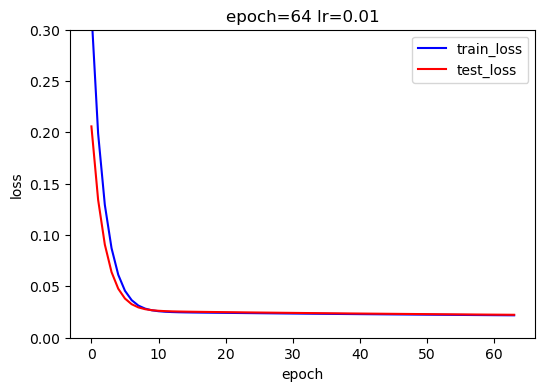

In [393]:
# 自定义数据集类
class MyDataset(Data.Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data.iloc[idx, :-1].values
        y = self.data.iloc[idx, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def plot_loss_epoch(epoch,train_loss,test_loss,title):
        
    fig = plt.figure(figsize=(6,4))
    plt.plot(epoch,train_loss,color='b',label='train_loss')
    plt.plot(epoch,test_loss,color='r',label='test_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.ylim(0,0.3)
    plt.title(title)
    plt.legend()
    plt.show()

def train_wine_quality(net:nn.Module,optimizer,epoches,lr,dataloader:Data.DataLoader,criterian):
    
    # save loss as epoch idx
    epoch_idx = []
    train_loss = []
    test_loss = []
    
    for epoch in range(epoches):
        
        # train loss
        net.eval()
        x = torch.tensor(train_df[:,:-1],dtype=torch.float32)
        y = torch.tensor(train_df[:,-1],dtype=torch.float32).reshape(-1,1)
        y_hat = net(x)
        tr_loss = criterian(y,y_hat)
        
        
        # train per epoch
        for x,y in dataloader:
            # calculate gradient
            y = y.reshape(-1,1)
            # print("x.shape",x.shape)
            # print("y.shape",y.shape)
            
            net.train()
            # forward
            
            # zero grad
            net.zero_grad()
            
            # forward 
            y_hat = net(x)
            
            # cal loss
            loss = criterian(y,y_hat)

            # back propagation
            loss.sum().backward()
            
            # step
            optimizer.step()
            
            
        # test loss
        net.eval()
        x = torch.tensor(test_df[:,:-1],dtype=torch.float32)
        y = torch.tensor(test_df[:,-1],dtype=torch.float32).reshape(-1,1)
        y_hat = net(x)
        te_loss = criterian(y,y_hat)
        
        # add to plot
        epoch_idx.append(epoch)
        test_loss.append(float(te_loss))
        train_loss.append(float(tr_loss))
        
    # plot
    print(train_loss)
    print(test_loss)
    plot_loss_epoch(epoch_idx,train_loss,test_loss,title=f'epoch={epoches} lr={lr}')


epoches = 64 # 训练次数
lr = 0.01 # 训练率
batch_size = 256# 批量大小

criterion = nn.MSELoss()

dataset_train = MyDataset('./wine_train.csv')
train_loader = Data.DataLoader(dataset=dataset_train,batch_size=batch_size,
                               shuffle=True,num_workers=0)

train_wine_quality(net=net,optimizer=optimizer,epoches=epoches,
                   lr=lr,dataloader=train_loader,criterian=criterion)



**<font color = blue size=4>第三部分:作业提交</font>**

一、实验课下课前提交完成代码，如果下课前未完成，请将已经完成的部分进行提交，未完成的部分于之后的实验报告中进行补充  
要求:  
1)文件格式为：学号-姓名.ipynb  
2)【不要】提交文件夹、压缩包、数据集等无关文件，只需提交单个ipynb文件即可

二、本次实验分为两周完成，实验报告提交截止日期: 12月15号14:20  
要求：  
1)文件格式为：学号-姓名.pdf  
2)【不要】提交文件夹、压缩包、代码文件、数据集等任何与实验报告无关的文件，只需要提交单个pdf文件即可  
3)文件命名时不需要额外添加“实验几”等额外信息，按照格式提交  

实验十二(神经网络)的实验报告上交地址: https://send2me.cn/Wk9FsyYO/SKCBsWeFtvwQsg

三、课堂课件获取地址:https://www.jianguoyun.com/p/DWHYtsEQp5WhChjwtKoFIAA
实验内容获取地址:https://www.jianguoyun.com/p/DbNY_SIQp5WhChjvtKoFIAA